This data wrangling project is divided into different stages, the first stage is Gathering Data 

In [1]:
#Gathering data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import json

#importing the first piece of data, twitter archive from a file and saving it as Pandas DataFrame
df_twitter_archive = pd.read_csv("twitter-archive-enhanced-2.csv")

#fetching the second data set from an online source 
url =  "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
folder_name = "image_predictions"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

file_name = url.split('/')[-1]
response = requests.get(url)
with open (os.path.join(folder_name, file_name),mode='wb') as file: file.write(response.content)
#Saved as Pandas DataFrame
df_image_predictions = pd.read_csv(os.path.join(folder_name, file_name))

#getting the third piece of data using a file genereated from querying twitter API, However I couldn't
    #query the API myself because I couldn't get a Twitter Developer Account
twitter_txt = "tweet-json copy" 

twitter_api_data = []

with open(twitter_txt, 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        fav_count = tweet['favorite_count']
        user_count = tweet['user']['followers_count']
        twitter_api_data.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': fav_count,
                       'user_count': user_count})
#Saved as Pandas DataFrame        
df_twitter_api_data = pd.DataFrame(twitter_api_data)

#Saving original copies of gathered data as CSV
df_twitter_archive.to_csv('df_twitter_archive.csv', index = False)
df_twitter_api_data.to_csv('df_twitter_api_data.csv', index = False)
df_image_predictions.to_csv('df_image_predictions.csv', index = False)



Second stage in the project is Data Assessment

In [2]:
#Assessing data
#Visual assessment of the three data sets using two methods,
    #first is viewing them in Juypter Notebook
df_twitter_archive
df_twitter_api_data
df_image_predictions

    #second is viewing them using an external program in a CSV format
df_twitter_archive.to_csv('df_twitter_archive.csv', index = False)
df_twitter_api_data.to_csv('df_twitter_api_data.csv', index = False)
df_image_predictions.to_csv('df_image_predictions.csv', index = False)

#Porgramatic assessment of the three data sets using info method
df_twitter_archive.info()
df_twitter_api_data.info()
df_image_predictions.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

Assessment results

Quality issues
    - twitter archive file has two columns about retweets that have many empty cells 
    - there are tweets that aren't original tweets instead retweets and replies
    - not found dog names are represented as None not NaN
    - dog types in twitter archive file contain None instead of Nan
    - some dog names are erroneous such as "a","an" and "the" 
    - timestamp column needs to be split into month and year columns for clarity
    - timestamp column needs to be converted to datetime in order to facilitate analysis
    - twitter api data file should be merged with twitter archive
    - in image predictions file, p1_conf and p1_dog are non descriptive column names
    - p2 and p3 are low confidence and low quality indicators

Tidiness issues
    - image predictions file doesn't have separate columns 
    - twitter archive file dog names should be merged into one column named dog type 

Third stage is Data Cleaning

In [3]:
#Cleaning data
#Define Problems 1: 
    #image predictions data is combined into a single column making it untidy
#Code and Fix: Splitting the column by white space between the data points
df_image_predictions = pd.read_csv(os.path.join(folder_name, file_name),delim_whitespace=True,header=0)
#Test: Each variable is stored into its own column
df_image_predictions

#Define Problems 2: 
    #1. Data doesn't contain only original tweets but also retweets which is appearnt in the fact that 
        # the twitter archive file has more data points than image predictions file
    #2. The three dataframes represent one observational unit meaning each tweet is associated with data in the three files 
#Code and Fix: Removing the retweets and merging the three data file, so most retweets are removed and data becomes more tidy
df_combined_twitter_data = pd.merge(df_twitter_archive, df_twitter_api_data, on=["tweet_id"])
df_combined_twitter_data = pd.merge(df_combined_twitter_data, df_image_predictions, on=["tweet_id"])
    #Removing more retweets
df_combined_twitter_data = df_combined_twitter_data[~df_combined_twitter_data["text"].str.contains("RT @")] 
#Test: Data is more tidy 
df_combined_twitter_data
df_combined_twitter_data.to_csv('df_combined_twitter_data.csv', index = False)

#Define Problems 3: 
    #1. Certian columns don't add value as most of their entries are empty such as "in_reply_to_status_id" and
        #"in_reply_to_user_id".
    #2. Dog classification names ie: doggo, floofer, pupper and puppo should be merged into one column named dog type 
    #3. p2 and p3 algorithims have low confidence and low added value 
#Code and Fix: Remove cloumns that are not needed and resturcture dog types data
df_combined_twitter_data = df_combined_twitter_data.drop(columns=["in_reply_to_status_id","in_reply_to_user_id",
                                                                  "retweeted_status_id","retweeted_status_user_id","retweeted_status_timestamp",
                                                                  "img_num","p2","p2_conf","p2_dog",
                                                                  "p3","p3_conf","p3_dog"])
df_combined_twitter_data["doggo"].replace(['None'], '', inplace=True)
df_combined_twitter_data["pupper"].replace(['None'], '', inplace=True)
df_combined_twitter_data["floofer"].replace(['None'], '', inplace=True)
df_combined_twitter_data["puppo"].replace(['None'], '', inplace=True)
df_combined_twitter_data["dog_type"] =df_combined_twitter_data["doggo"].astype(str) + df_combined_twitter_data["pupper"].astype(str) +df_combined_twitter_data["floofer"].astype(str) +df_combined_twitter_data["puppo"].astype(str)
df_combined_twitter_data["dog_type"].replace([''], np.nan, inplace=True)
df_combined_twitter_data = df_combined_twitter_data.drop(columns=["doggo","pupper","floofer","puppo"])
#Test: Data is more tidy 
df_combined_twitter_data.to_csv('df_combined_twitter_data.csv', index = False)
df_combined_twitter_data 


#Define Problems 4: 
    #1. Certian columns have non descriptive names such as p1_conf and p1_dog
    #2. Some dog names are represented as None instead of NaN 
    #3. Some dog names are represented as "a" incorrectly
#Code and Fix: Change column names and replace invalid dog names
df_combined_twitter_data = df_combined_twitter_data.rename(columns={'p1_conf': 'p1_confidence', 'p1_dog': 'is_dog?'})

df_combined_twitter_data['name'].replace('None', np.nan, inplace=True)
df_combined_twitter_data['name'].replace(['a','an','the'], np.nan, inplace=True)

#Test: Data is more readable 
df_combined_twitter_data.to_csv('df_combined_twitter_data.csv', index = False)
df_combined_twitter_data.info()

#Define Problems 5:
    #1. timestamp column needs to be broken down into month, year and month_year columns 
        # so that each variable is a column and in order to be used in analysis
    #2. timestamp column needs to be converted to datetime in order to facilitate analysis
#Code and Fix: Extracting Date Data from timestamp and converting it into datatime
df_combined_twitter_data["timestamp"] = pd.to_datetime(df_combined_twitter_data["timestamp"])
df_combined_twitter_data["month"] = pd.DatetimeIndex(df_combined_twitter_data["timestamp"]).month 
df_combined_twitter_data["year"] = pd.DatetimeIndex(df_combined_twitter_data["timestamp"]).year
df_combined_twitter_data["month_year"] = pd.to_datetime(df_combined_twitter_data["timestamp"]).dt.to_period('M') 
#Test: Data can be easily analysed now
df_combined_twitter_data




<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 16 columns):
tweet_id              1994 non-null int64
timestamp             1994 non-null object
source                1994 non-null object
text                  1994 non-null object
expanded_urls         1994 non-null object
rating_numerator      1994 non-null int64
rating_denominator    1994 non-null int64
name                  1380 non-null object
favorite_count        1994 non-null int64
retweet_count         1994 non-null int64
user_count            1994 non-null int64
jpg_url               1994 non-null object
p1                    1994 non-null object
p1_confidence         1994 non-null float64
is_dog?               1994 non-null bool
dog_type              306 non-null object
dtypes: bool(1), float64(1), int64(6), object(8)
memory usage: 251.2+ KB


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorite_count,retweet_count,user_count,jpg_url,p1,p1_confidence,is_dog?,dog_type,month,year,month_year
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,39467,8853,3200889,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,orange,0.097049,False,NaN,8,2017,2017-08
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,33819,6514,3200889,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,True,NaN,8,2017,2017-08
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,25461,4328,3200889,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,True,NaN,7,2017,2017-07
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,42908,8964,3200889,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,paper_towel,0.170278,False,NaN,7,2017,2017-07
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,41048,9774,3200889,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,True,NaN,7,2017,2017-07
5,891087950875897856,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,NaN,20562,3261,3200889,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,Chesapeake_Bay_retriever,0.425595,True,NaN,7,2017,2017-07
6,890971913173991426,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,12041,2158,3200889,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,Appenzeller,0.341703,True,NaN,7,2017,2017-07
7,890729181411237888,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,NaN,56848,16716,3200889,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,Pomeranian,0.566142,True,NaN,7,2017,2017-07
8,890609185150312448,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,28226,4429,3200889,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,Irish_terrier,0.487574,True,NaN,7,2017,2017-07
9,890240255349198849,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,32467,7711,3200889,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,Pembroke,0.511319,True,doggo,7,2017,2017-07


Fourth stage is Data Sorting

In [4]:
#Sorting Data
#Combining all data sets into one tidy master dataframe
twitter_archive_master = df_combined_twitter_data
twitter_archive_master.to_csv('Twitter_archive_master.csv', index = False)

Average Favorite Count Per Tweet with a Dog is  9288.48138118
Average Favorite Count Per Tweet without a Dog is  7773.67504836


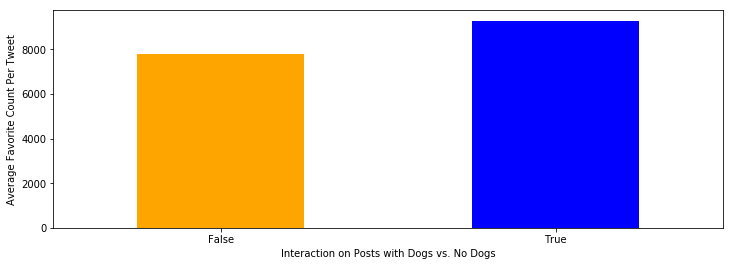

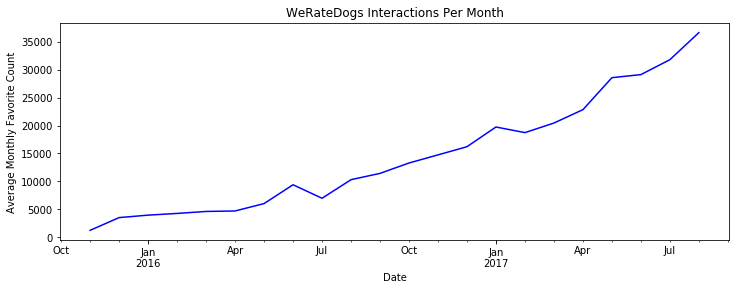

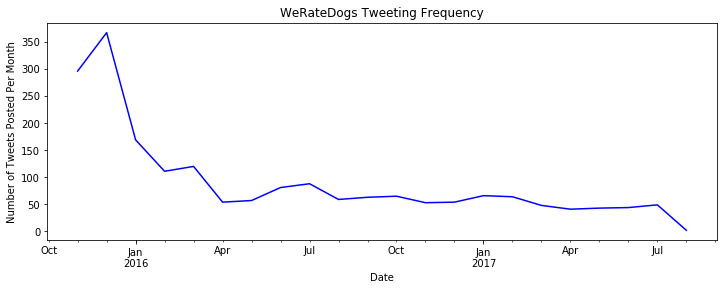

In [8]:
#Analyzing and Visualizing data
#Gaguing interactions one posts that contains dogs versus posts that doesn't contain dogs
twitter_archive_master_dogs = twitter_archive_master[twitter_archive_master["is_dog?"] == True]
dogs_interaction = twitter_archive_master_dogs["favorite_count"].mean()

twitter_archive_master_no_dogs = twitter_archive_master[twitter_archive_master["is_dog?"] == False]
no_dogs_interaction = twitter_archive_master_no_dogs["favorite_count"].mean()
print("Average Favorite Count Per Tweet with a Dog is ",dogs_interaction)
print("Average Favorite Count Per Tweet without a Dog is ",no_dogs_interaction)

#Plotting the analysis
fig, axs = plt.subplots(figsize=(12, 4))
twitter_archive_master.groupby(twitter_archive_master["is_dog?"])["favorite_count"].mean().plot(kind='bar', rot=0,color=['orange','blue'], ax=axs)

plt.xlabel("Interaction on Posts with Dogs vs. No Dogs")
plt.ylabel("Average Favorite Count Per Tweet");


#Monitering monthly average interaction per tweet
fig, axs = plt.subplots(figsize=(12, 4))
twitter_archive_master["timestamp"] = pd.to_datetime(twitter_archive_master["timestamp"])
twitter_archive_master.groupby(twitter_archive_master["timestamp"].dt.to_period('M'))["favorite_count"].mean().plot(title='WeRateDogs Interactions Per Month',kind='line', rot=0,color='blue', ax=axs)

plt.xlabel("Date");
plt.ylabel("Average Monthly Favorite Count");


#Plotting the number of tweets posted per month trend
fig, axs = plt.subplots(figsize=(12, 4))
twitter_archive_master["timestamp"] = pd.to_datetime(twitter_archive_master["timestamp"])
twitter_archive_master.groupby(twitter_archive_master["timestamp"].dt.to_period('M'))["tweet_id"].count().plot(title='WeRateDogs Tweeting Frequency',kind='line', rot=0,color='blue', ax=axs)

plt.xlabel("Date");
plt.ylabel("Number of Tweets Posted Per Month");



Three important takeways from the above graphs and analysis are as follows:
    1. It's both clear and logical that tweets that contain dog pictures gain more attraction than those who don't, as tweets with dogs have an average favorite count of about 9288 while those who don't have dog pictures gain 7773 which is considerably lower.
    2. WeRateDogs had a slow and normal start with low interactions on each post as shown in their low average monthly favorite count in their start, but as time went on, their posts kept picking up speed and attention in a very impressive pace.
    3. It appears that WeRateDogs slowed down on their tweets rate as they gained more followers. This is can be seen in the third graph where their number of monthly tweets had a sharp dip compared to their early months. 
    